# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

## Подготовка данных

In [1]:
import warnings
import pandas as pd
import re
from itertools import groupby
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
try:
    gold_full  = pd.read_csv('gold_industry_full.csv')
    gold_train = pd.read_csv('gold_industry_train.csv')
    gold_test  = pd.read_csv('gold_industry_test.csv')
except FileNotFoundError:
    gold_full  = pd.read_csv('####')
    gold_train = pd.read_csv('####')
    gold_test  = pd.read_csv('####')

In [4]:
# Оценим с чем придется работать
gold_full.info()
gold_train.info()
gold_test.info()
display(gold_full.describe().T)
display(gold_train.describe().T)
display(gold_test.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   rougher.input.feed_au                               19439 non-null  float64
 2   rougher.input.feed_ag                               19439 non-null  float64
 3   rougher.input.feed_pb                               19339 non-null  float64
 4   rougher.input.feed_sol                              19340 non-null  float64
 5   rougher.input.feed_rate                             19428 non-null  float64
 6   rougher.input.feed_size                             19294 non-null  float64
 7   rougher.input.floatbank10_sulfate                   19405 non-null  float64
 8   rougher.input.floatbank10_xanthate                  19431 non-null  float64


,count,mean,std,min,25%,50%,75%,max
rougher.input.feed_au,19439.0,8.266097,1.955092,0.010000,6.854384,8.125839,9.769917,13.731330
rougher.input.feed_ag,19439.0,8.794927,1.936847,0.010000,7.237967,8.593574,10.213771,14.596026
rougher.input.feed_pb,19339.0,3.598085,1.049486,0.010000,2.887280,3.534895,4.244161,7.142594
rougher.input.feed_sol,19340.0,36.695114,5.145445,0.010000,34.207799,37.202650,40.039133,53.477742
rougher.input.feed_rate,19428.0,478.320042,105.373758,0.002986,416.525453,499.416120,550.172183,717.508837
...,...,...,...,...,...,...,...,...
final.output.recovery,19439.0,67.050208,10.125840,0.000000,63.299712,68.172738,72.686642,100.000000
final.output.tail_au,19439.0,3.042467,0.922808,0.000000,2.461138,2.984909,3.571351,8.245022
final.output.tail_ag,19438.0,9.688589,2.328642,0.000000,8.062878,9.743623,11.134294,19.552149
final.output.tail_pb,19338.0,2.705795,0.949077,0.000000,2.040119,2.748730,3.333216,5.804178


,count,mean,std,min,25%,50%,75%,max
rougher.input.feed_au,14579.0,8.352941,1.934376,0.010000,6.932996,8.225284,9.832210,13.731330
rougher.input.feed_ag,14579.0,8.877460,1.922536,0.010000,7.341922,8.715859,10.255843,14.596026
rougher.input.feed_pb,14507.0,3.604221,1.056063,0.010000,2.880490,3.532399,4.257282,7.052325
rougher.input.feed_sol,14502.0,36.561420,5.209823,0.010000,34.093951,37.097511,39.899799,53.475325
rougher.input.feed_rate,14572.0,474.332784,108.503552,0.002986,411.048483,498.187968,549.586552,717.508837
...,...,...,...,...,...,...,...,...
final.output.recovery,14579.0,66.759066,10.619709,0.000000,63.114596,67.962788,72.598187,100.000000
final.output.tail_au,14579.0,3.087939,0.915187,0.000000,2.505287,3.029238,3.614098,8.245022
final.output.tail_ag,14578.0,9.731972,2.358143,0.000000,8.088928,9.818512,11.169187,19.552149
final.output.tail_pb,14504.0,2.719985,0.958929,0.000000,2.036512,2.774847,3.353845,5.804178


,count,mean,std,min,25%,50%,75%,max
rougher.input.feed_au,4860.0,8.005584,1.993590,1.000000e-02,6.574363,7.812923,9.556589,13.417156
rougher.input.feed_ag,4860.0,8.547348,1.958601,1.000000e-02,6.975898,8.179714,10.084339,14.533698
rougher.input.feed_pb,4832.0,3.579662,1.029377,1.000000e-02,2.903612,3.540772,4.199847,7.142594
rougher.input.feed_sol,4838.0,37.095864,4.926284,1.000000e-02,34.510841,37.499761,40.461315,53.477742
rougher.input.feed_rate,4856.0,490.285103,94.371623,1.278570e-02,434.099695,502.118742,555.596563,702.523396
rougher.input.feed_size,4816.0,59.113400,19.125122,4.636880e-02,47.596984,55.509481,66.661547,363.989699
rougher.input.floatbank10_sulfate,4857.0,12.055735,3.407642,1.890695e-02,9.890429,11.997859,14.496072,30.010759
rougher.input.floatbank10_xanthate,4859.0,6.101308,1.042754,1.578303e-02,5.499808,6.099805,6.802101,9.396928
rougher.state.floatbank10_a_air,4859.0,1108.635895,156.493143,3.007925e+02,999.715729,1001.414798,1202.837565,1521.980372
rougher.state.floatbank10_a_level,4859.0,-368.340127,91.155929,-6.005681e+02,-499.731972,-300.181367,-299.961547,-281.039299


Все столбцы кроме столбца с датой числовые. Есть пропущенные значения. Есть столбцы которые отличаются на порядки, поэтому понадобится шкалирование. Посмотрим как распределена дата между тренировочной и тестовой выборками.

In [5]:
display(pd.to_datetime(gold_train.date).describe())
display(pd.to_datetime(gold_test.date).describe())

count                            14579
mean     2017-01-02 11:20:41.195349760
min                2016-01-15 00:00:00
25%                2016-07-17 05:29:59
50%                2016-12-31 11:59:59
75%                2017-06-29 02:29:59
max                2017-12-09 13:59:59
Name: date, dtype: object

count                             4860
mean     2018-04-17 21:20:42.703703808
min                2017-12-09 14:59:59
25%                2018-02-20 02:44:59
50%                2018-04-20 06:29:59
75%                2018-06-15 14:14:59
max                2018-08-18 10:59:59
Name: date, dtype: object

Видно что выборка разбита на тренировочную и тестовую части по признаку даты.

In [6]:
# Проверим что эффективность обогащения рассчитана правильно.
def recovery(output_concentrate_au, input_feed_au, output_tail_au):
    return (output_concentrate_au*(input_feed_au-output_tail_au))/(input_feed_au*(output_concentrate_au-output_tail_au))*100

roughed_recovery_calc = (
    recovery(gold_train['rougher.output.concentrate_au'], gold_train['rougher.input.feed_au'], gold_train['rougher.output.tail_au']))

mean_absolute_error(gold_train['rougher.output.recovery'], roughed_recovery_calc)

9.83758577644259e-15

Ошибка около нуля, эффективность обогащения рассчитана правильно.

In [7]:
# Проверим какие столбцы отсутствуют в тестовом наборе данных
print(missing_cols := set(gold_train.columns) - set(gold_test.columns))

{'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.tail_au', 'secondary_cleaner.output.tail_pb', 'final.output.recovery', 'primary_cleaner.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.tail_sol', 'final.output.concentrate_pb', 'final.output.concentrate_ag', 'secondary_cleaner.output.tail_sol', 'final.output.tail_sol', 'final.output.tail_pb', 'rougher.output.tail_ag', 'rougher.calculation.sulfate_to_au_concentrate', 'final.output.concentrate_sol', 'rougher.output.tail_pb', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'final.output.tail_au', 'rougher.output.tail_au', 'primary_cleaner.output.tail_pb', 'rougher.output.recovery', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.concentrate_sol', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'primary_cleaner.output.concentrate_ag', 'rougher.output.concentrate_sol', 'primary_cleaner.output.tail_sol', 'rougher.output.concentrate_pb', 'rougher.calculation.au_pb_ratio', 'seconda

В тестовом наборе данных отсутствуют признаки связанные с концентрацией металлов на выходе, в том числе в хвостах. А также некоторые расчётные показатели, которые могут привести к утечке данных. Количество признаков между train и test расходится потому что некоторые метрики нельзя измерить на месте, например, возможно, для измерения концентрации метала надо отнести образцы в лабораторию. Другими словами train условно исторические данные, а test данные которые мы только получили и некоторые признаки ещё просто не успели добавить.

In [8]:
# Подготовим данные и заполним пропущенные данные
# Столбец с датой для предсказания мы использовать не будем,
# но информация нам нужна, поэтому запишем его в индекс.
print('проверим столбец на дубликаты, full df', sum(gold_full.date.duplicated()))
print('проверим столбец на дубликаты, train df', sum(gold_train.date.duplicated()))
print('проверим столбец на дубликаты, test df', sum(gold_test.date.duplicated()))
gold_full.index = pd.to_datetime(gold_full.date)
gold_full.drop('date', inplace=True, axis=1)
gold_train.index = pd.to_datetime(gold_train.date)
gold_train.drop('date', inplace=True, axis=1)
gold_test.index = pd.to_datetime(gold_test.date)
gold_test.drop('date', inplace=True, axis=1)

проверим столбец на дубликаты, full df 0
проверим столбец на дубликаты, train df 0
проверим столбец на дубликаты, test df 0


__ВЫВОД__: На данном этапе работы была проведена первоначальная оценка данных, оценена правильность рассчёта эффективности обогащения. Найдены столбцы которые отсутствуют в тестовом наборе данных, удалён столбец с датой, который стал теперь индексом.

In [9]:
# Как мы могли убедиться выше, пропущенных значений по каждому столбцу не очень много,
# поэтому заполним методом обратного направления. Следующее значение подставляется вместо предыдущего.
gold_test.fillna(method='bfill', inplace=True)
gold_train.fillna(method='bfill', inplace=True)

## Анализ данных

In [10]:
# Сравним концентрации металлов золота, серебра и свинца на разных стадиях.
def get_metal_cols(metal):
    return [f'rougher.input.feed_{metal}'] + [
        m for m in gold_full.columns if re.search('concentrate_'+metal, m)
    ]
au_cols = get_metal_cols('au')
ag_cols = get_metal_cols('ag')
pb_cols = get_metal_cols('pb')
display(gold_full[au_cols].describe())
display(gold_full[ag_cols].describe())
display(gold_full[pb_cols].describe())
gold_train.columns

,rougher.input.feed_au,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au
count,19439.000000,19439.000000,19439.000000,19439.000000
mean,8.266097,19.772000,32.119400,44.076513
std,1.955092,3.753600,5.627611,5.129784
min,0.010000,0.000000,0.000000,0.000000
25%,6.854384,18.802523,30.463140,43.402215
50%,8.125839,20.280214,32.841295,45.011244
75%,9.769917,21.717843,35.048006,46.275313
max,13.731330,28.824507,45.933934,52.756638


,rougher.input.feed_ag,rougher.output.concentrate_ag,primary_cleaner.output.concentrate_ag,final.output.concentrate_ag
count,19439.000000,19439.000000,19439.000000,19438.000000
mean,8.794927,11.994759,8.442408,5.168470
std,1.936847,2.733862,2.054465,1.372348
min,0.010000,0.000000,0.000000,0.000000
25%,7.237967,10.628337,7.263288,4.251240
50%,8.593574,12.098115,8.507298,5.066094
75%,10.213771,13.736996,9.809001,5.895527
max,14.596026,24.480271,16.081632,16.001945


,rougher.input.feed_pb,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,final.output.concentrate_pb
count,19339.000000,19439.000000,19323.000000,19438.000000
mean,3.598085,7.606272,9.829530,9.978895
std,1.049486,1.796757,2.556843,1.669240
min,0.010000,0.000000,0.000000,0.000000
25%,2.887280,6.725987,8.702328,9.137262
50%,3.534895,7.742580,10.152433,10.102433
75%,4.244161,8.565199,11.424971,11.035769
max,7.142594,13.617072,17.081278,17.031899


Index(['rougher.input.feed_au', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_sol',
       'rougher.input.feed_rate', 'rougher.input.feed_size',
       'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_f

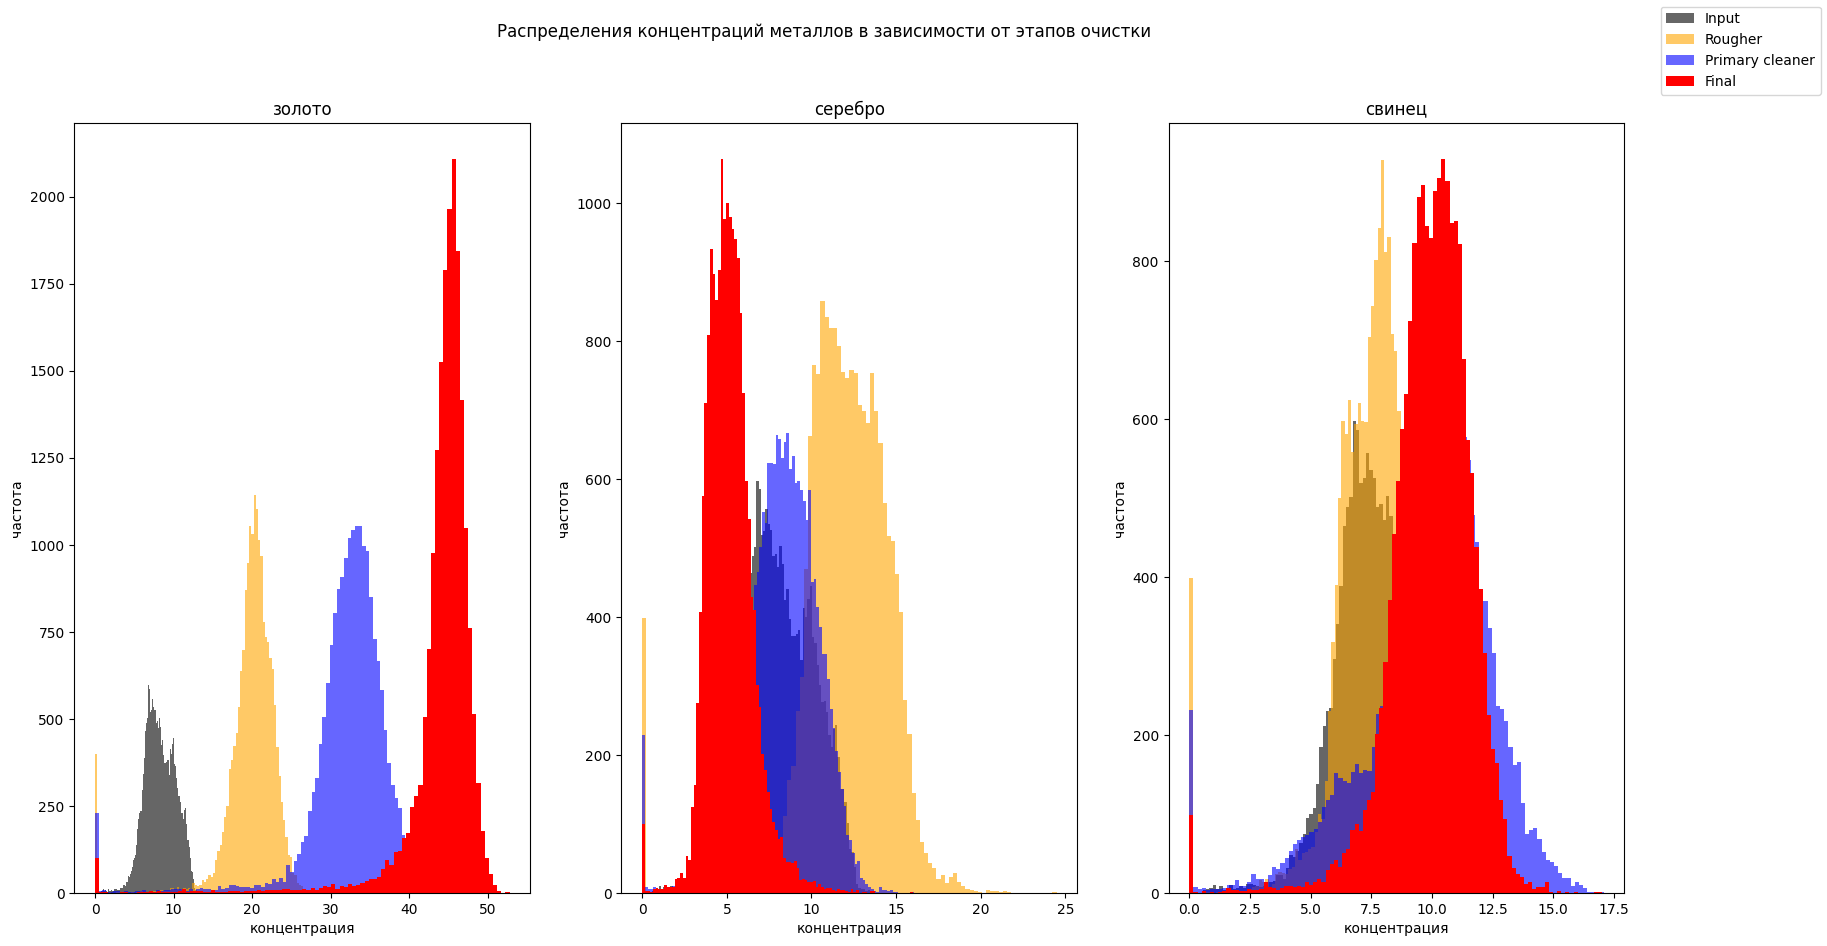

In [11]:
# Для наглядности построим график
figure, axis = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))

axis[0].hist(gold_full[au_cols].iloc[:, 0], bins=100, color='black', alpha=0.6, label='Input')
axis[0].hist(gold_full[au_cols].iloc[:, 1], bins=100, color='orange', alpha=0.6, label='Rougher')
axis[0].hist(gold_full[au_cols].iloc[:, 2], bins=100, color='blue', alpha=0.6, label='Primary cleaner')
axis[0].hist(gold_full[au_cols].iloc[:, 3], bins=100, color='red', label='Final')
axis[0].set_xlabel('концентрация')
axis[0].set_ylabel('частота')
axis[0].set_title('золото')
axis[1].hist(gold_full[au_cols].iloc[:, 0], bins=100, color='black', alpha=0.6, label='Input')
axis[1].hist(gold_full[ag_cols].iloc[:, 1], bins=100, color='orange', alpha=0.6, label='Rougher')
axis[1].hist(gold_full[ag_cols].iloc[:, 2], bins=100, color='blue', alpha=0.6, label='Primary cleaner')
axis[1].hist(gold_full[ag_cols].iloc[:, 3], bins=100, color='red', label='Final')
axis[1].set_xlabel('концентрация')
axis[1].set_ylabel('частота')
axis[1].set_title('серебро')
axis[2].hist(gold_full[au_cols].iloc[:, 0], bins=100, color='black', alpha=0.6, label='Input')
axis[2].hist(gold_full[pb_cols].iloc[:, 1], bins=100, color='orange', alpha=0.6, label='Rougher')
axis[2].hist(gold_full[pb_cols].iloc[:, 2], bins=100, color='blue', alpha=0.6, label='Primary cleaner')
axis[2].hist(gold_full[pb_cols].iloc[:, 3], bins=100, color='red', label='Final')
axis[2].set_xlabel('концентрация')
axis[2].set_ylabel('частота')
axis[2].set_title('свинец')
figure.suptitle('Распределения концентраций металлов в зависимости от этапов очистки');
handles, labels = axis[0].get_legend_handles_labels()
figure.legend(handles, labels);

Из распределений видно что концентрация золота растёт, концентрация серебра немного повышается после флотации, но снижается на остальных этапах очистки, в то время как концентрация свинца незначительно увеличивается после флотации, но практически не меняется после. Также на графиках обнаружились значения, где концентрация металла равна 0, во всех случаях больше всего таких значений на этапе флотации и меньше всего после второй очистки.

In [12]:
# Нулевая концентрация металлов это явный артефакт, поэтому надо удалить такие наблюдения.
threshold = 1e-1
conc_metal_cols = au_cols + ag_cols + pb_cols
for conc in conc_metal_cols:
    gold_train.drop(gold_train[gold_train[conc]<threshold].index, inplace=True)

In [13]:
# Проверим что такие наблюдения удалены из тренировочного датасета
gold_train[gold_train[conc_metal_cols[0]]<threshold].index

DatetimeIndex([], dtype='datetime64[ns]', name='date', freq=None)

Артефакты успешно удалены

In [14]:
# Сравним размер гранул между тренировочной и тестовой выборками
display(gold_train['rougher.input.feed_size'].describe())
display(gold_test['rougher.input.feed_size'].describe())
# Выглядит очень похоже

count    13881.000000
mean        58.810206
std         23.356806
min          0.049194
25%         47.166841
50%         54.313886
75%         64.228440
max        484.967466
Name: rougher.input.feed_size, dtype: float64

count    4860.000000
mean       59.080175
std        19.441844
min         0.046369
25%        47.605339
50%        55.414175
75%        66.538910
max       363.989699
Name: rougher.input.feed_size, dtype: float64

H0: разницы между средним значением размера гранул в тренировочной и тестовой выборке нет, 
H1: разница между средним значением размера гранул в тренировочной и тестовой выборке есть
P-value: 0.4301274126223197
pval > alpha, не можем отвергнуть H_0 в пользу H_1, размер гранул одинаковый.


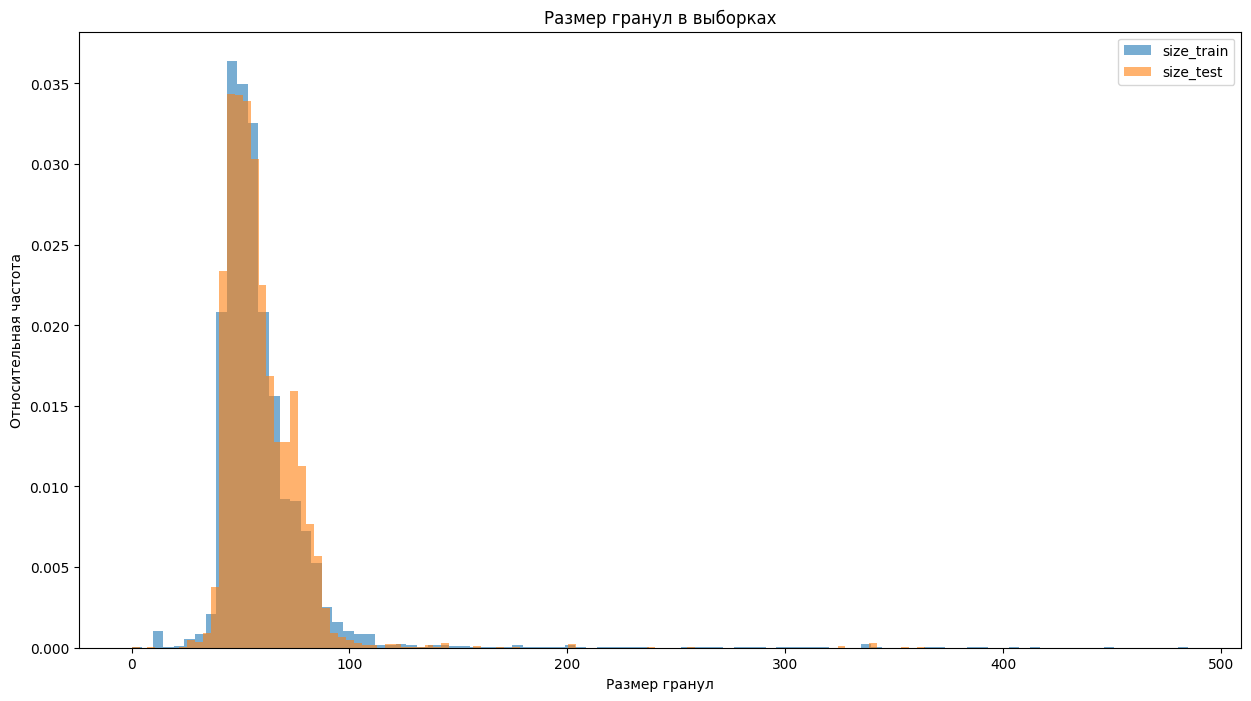

In [15]:
# Докажем что выборки равны, попытавшись доказать обратное.
pval = st.ttest_ind(gold_train['rougher.input.feed_size'], 
                    gold_test['rougher.input.feed_size'],
                    equal_var=False
                   ).pvalue
print('''H0: разницы между средним значением размера гранул в тренировочной и тестовой выборке нет, 
H1: разница между средним значением размера гранул в тренировочной и тестовой выборке есть''')
print('P-value:', pval)
if pval < 0.05:
    print('pval < alpha, H_0 отвергается, выборки не равны, размер гранул разный')
else:
    print('pval > alpha, не можем отвергнуть H_0 в пользу H_1, размер гранул одинаковый.')
figure, axis = plt.subplots(figsize=(15, 8))
axis.hist(gold_train['rougher.input.feed_size'], bins=100, density=True, alpha=0.6, label='size_train')
axis.hist(gold_test['rougher.input.feed_size'], bins=100, density=True, alpha=0.6, label='size_test')
axis.set_xlabel('Размер гранул')
axis.set_ylabel('Относительная частота')
axis.set_title('Размер гранул в выборках')
axis.legend();

Можно статистически обоснованно считать что размер гранул одинаковый. Также на графике видно что распределения почти полностью перекрывают друг друга.

,rougher.input.feed,rougher.output.concentrate,primary_cleaner.output.concentrate,final.output.concentrate
count,19439.000000,19439.000000,19439.000000,19439.000000
mean,20.640600,39.373032,50.332682,59.223099
std,4.494362,6.863389,7.671672,6.097603
min,0.030000,0.000000,0.000000,0.000000
25%,17.252879,38.394639,50.038524,59.298323
50%,20.141216,40.312648,51.905758,60.306921
75%,23.797381,42.365102,53.386172,61.096667
max,33.498784,55.568687,60.269003,64.968881


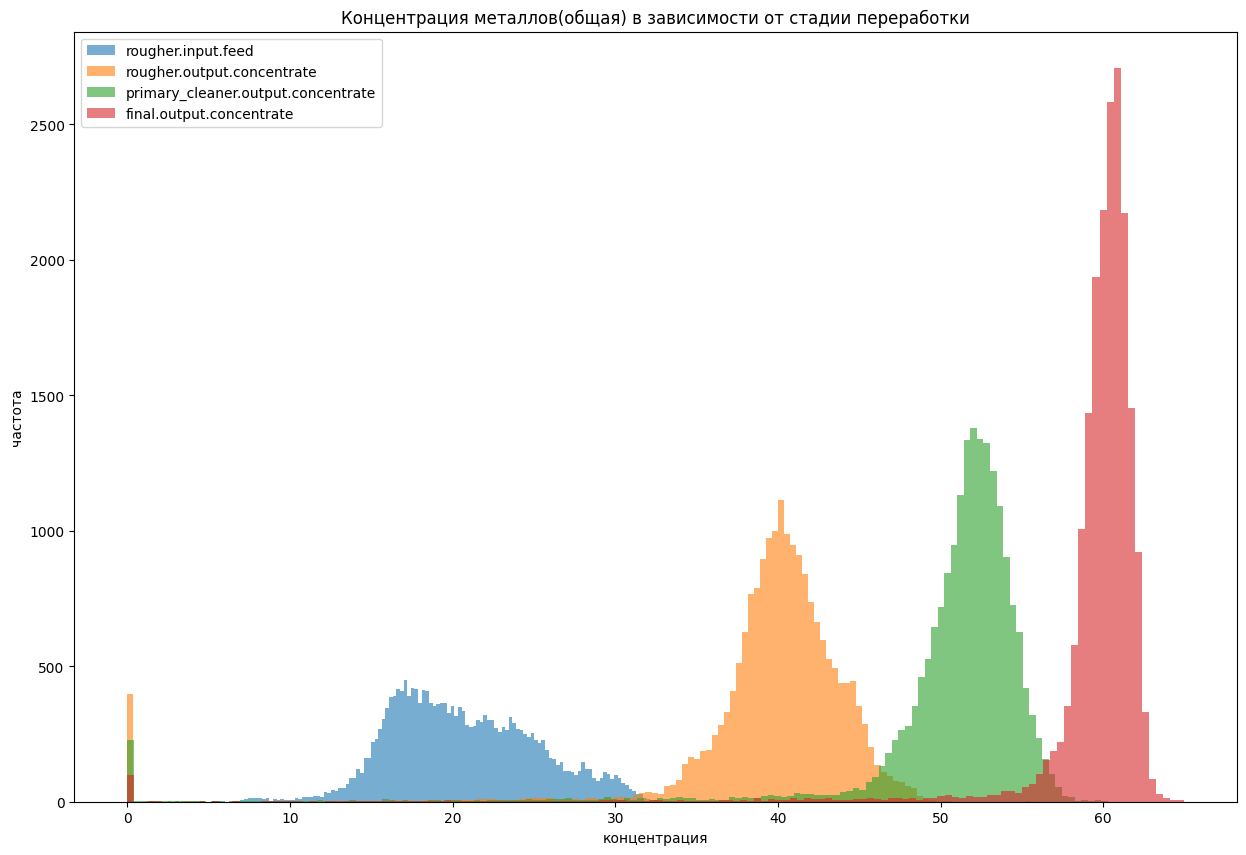

In [16]:
# Исследуем суммарную концентрацию металлов на разных стадиях. Начнём с подготовки данных.
total_concentration_cols = []
for metal in ('au', 'ag', 'pb'):
    total_concentration_cols.extend([column for column in gold_full.columns if re.search('(concentrate|feed)', column) and column.endswith(metal)])
total_concentration_cols_grouped = {}
for key, val in groupby(total_concentration_cols, lambda x: x.rsplit('_', 1)[0]):
    total_concentration_cols_grouped.setdefault(key, []).extend(val)
total_concentration_cols_sum = {}
for key, val in total_concentration_cols_grouped.items():
    total_concentration_cols_sum[key] = gold_full[val].sum(axis=1)
total_concentration_cols_sum = pd.DataFrame(total_concentration_cols_sum)
# Теперь можно приступить к анализу
display(total_concentration_cols_sum.describe())
figure, axis = plt.subplots(figsize=(15, 10))
axis.hist(total_concentration_cols_sum.iloc[:, 0], bins=150, alpha=0.6, label=total_concentration_cols_sum.columns[0])
axis.hist(total_concentration_cols_sum.iloc[:, 1], bins=150, alpha=0.6, label=total_concentration_cols_sum.columns[1])
axis.hist(total_concentration_cols_sum.iloc[:, 2], bins=150, alpha=0.6, label=total_concentration_cols_sum.columns[2])
axis.hist(total_concentration_cols_sum.iloc[:, 3], bins=150, alpha=0.6, label=total_concentration_cols_sum.columns[3])
axis.legend()
axis.set_xlabel('концентрация')
axis.set_ylabel('частота')
axis.set_title('Концентрация металлов(общая) в зависимости от стадии переработки');

Видно, что концентрация стабильно растёт от исходного сырья к финальному концентрату. Распределения у стадий похожи на нормальное, за исключением концентрации на этапе флотации. Наименьшая сигма визуально у финального сырья. С учетом того как выглядят распределения по стадиям для отдельных металлов концентрация растёт в основном за счёт золота. __Нули__ из тренировочного и тестового датасетов были заполнены медианой выше.

__ВЫВОД__: На этом этапе были сравнены распределения концентраций: концентрация золота стабильно растёт в зависимости от стадии переработки. Затем были сравнены размеры гранул: разницы между ними не оказалось. После чего были посторены гистограммы распределения для всех стадий очистки по сумме концентраций металлов: концентрация металлов растёт одновременно со стадией очистки. 

## Модель

In [17]:
# Подготовим данные для моделирования, попробуем заполнить отсутствующие столбцы 
# в тестовой выборке из полной датасета.
target_cols = [col for col in list(missing_cols) if col.endswith('recovery')]
gold_test = gold_test.join(gold_full[target_cols].loc[gold_test.index, :])

In [18]:
gold_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4860 entries, 2017-12-09 14:59:59 to 2018-08-18 10:59:59
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rougher.input.feed_au                       4860 non-null   float64
 1   rougher.input.feed_ag                       4860 non-null   float64
 2   rougher.input.feed_pb                       4860 non-null   float64
 3   rougher.input.feed_sol                      4860 non-null   float64
 4   rougher.input.feed_rate                     4860 non-null   float64
 5   rougher.input.feed_size                     4860 non-null   float64
 6   rougher.input.floatbank10_sulfate           4860 non-null   float64
 7   rougher.input.floatbank10_xanthate          4860 non-null   float64
 8   rougher.state.floatbank10_a_air             4860 non-null   float64
 9   rougher.state.floatbank10_a_level           4860 

In [19]:
target_cols

['final.output.recovery', 'rougher.output.recovery']

In [20]:
# создадим целевые признаки
train_target_rougher = gold_train['rougher.output.recovery']
gold_train.drop('rougher.output.recovery', axis=1, inplace=True)
train_target_final = gold_train['final.output.recovery']
gold_train.drop('final.output.recovery', axis=1, inplace=True)
test_target_rougher = gold_test['rougher.output.recovery']
gold_test.drop('rougher.output.recovery', axis=1, inplace=True)
test_target_final = gold_test['final.output.recovery']
gold_test.drop('final.output.recovery', axis=1, inplace=True)

In [21]:
# Удалим столбцы которых нет в тестовой таблице чтобы избежать утечки данных
gold_train.drop(missing_cols, axis=1, inplace=True, errors='ignore')
gold_test.drop(missing_cols, axis=1, inplace=True, errors='ignore')

Данные подготовлены для моделирования.

In [22]:
# Напишем функцию sMAPE
def smape(target, pred):
    diff_ = (target - pred).abs()
    sum_ = (target + pred)/2
    percent_ = diff_/sum_*100
    return percent_.sum()/len(percent_)

def resulting_smape(smape_rougher, smape_final):
    return 0.25*smape_rougher+0.75*smape_final

In [23]:
scorer = make_scorer(smape, greater_is_better=False)

In [24]:
# Приступим к моделированию
# Для начала выберем лучшую модель на параметрах по умолчанию,
# а затем проведём тюнинг гиперпараметров лучшей модели.
# Для начала попробуем модель Ridge
model_r_pipe = Pipeline([('scaler', StandardScaler()), ('model', Ridge(random_state=44))])
smape_score_r_pipe_rougher = cross_val_score(
    model_r_pipe, gold_train, train_target_rougher, cv=10, scoring=scorer).mean()*-1
print(f'sMAPE_avg ROUGHER = {smape_score_r_pipe_rougher}')
model_r_pipe = Pipeline([('scaler', StandardScaler()), ('model', Ridge())])
smape_score_r_pipe_final = cross_val_score(
    model_r_pipe, gold_train, train_target_final, cv=10, scoring=scorer).mean()*-1
print(f'sMAPE_avg FINAL = {smape_score_r_pipe_final}')
print(f'resulting sMAPE = {resulting_smape(smape_score_r_pipe_rougher, smape_score_r_pipe_final)}')

sMAPE_avg ROUGHER = 5.921823506834833
sMAPE_avg FINAL = 9.619010568932396
resulting sMAPE = 8.694713803408005


In [25]:
# Посмотрим на линейную регрессию
model_l_pipe = Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())])
smape_score_l_pipe_rougher = cross_val_score(
    model_l_pipe, gold_train, train_target_rougher, cv=10, scoring=scorer).mean()*-1
print(f'sMAPE_avg ROUGHER = {smape_score_l_pipe_rougher}')
model_l_pipe = Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())])
smape_score_l_pipe_final = cross_val_score(
    model_l_pipe, gold_train, train_target_final, cv=10, scoring=scorer).mean()*-1
print(f'sMAPE_avg FINAL = {smape_score_l_pipe_final}')
print(f'resulting sMAPE = {resulting_smape(smape_score_l_pipe_rougher, smape_score_l_pipe_final)}')

sMAPE_avg ROUGHER = 5.922308123711574
sMAPE_avg FINAL = 9.619223888488799
resulting sMAPE = 8.694994947294493


In [26]:
model_lo_pipe = Pipeline([('scaler', StandardScaler()), ('model', Lasso(random_state=44))])
smape_score_lo_pipe_rougher = cross_val_score(
    model_lo_pipe, gold_train, train_target_rougher, cv=10, scoring=scorer).mean()*-1
print(f'sMAPE_avg ROUGHER = {smape_score_lo_pipe_rougher}')
model_lo_pipe = Pipeline([('scaler', StandardScaler()), ('model', Lasso(random_state=44))])
smape_score_lo_pipe_final = cross_val_score(
    model_lo_pipe, gold_train, train_target_final, cv=10, scoring=scorer).mean()*-1
print(f'sMAPE_avg FINAL = {smape_score_lo_pipe_final}')
print(f'resulting sMAPE = {resulting_smape(smape_score_lo_pipe_rougher, smape_score_lo_pipe_final)}')

sMAPE_avg ROUGHER = 6.090250394403746
sMAPE_avg FINAL = 8.741062367244645
resulting sMAPE = 8.07835937403442


По результатам кросс валидации с минимальным отрывом от линейной регрессии побеждает модель Ridge. Лассо показала наихудший результат.

In [27]:
# Оценим модель с двумя гиперпараметрами
model_en_pipe = Pipeline([('scaler', StandardScaler()), ('model', RandomForestRegressor(random_state=44))])
param_grid = {
    'model__n_estimators': np.arange(10, 31, 10),
    'model__max_depth': [None] + [i for i in range(2, 7)]
}
# Финальная проверка, что все ячейки работают перед отправкой на ревью. Параметры уже подобраны ранее.
param_grid = {
    'model__n_estimators': [10],
    'model__max_depth': [5]
}

In [28]:
grid_search_en = GridSearchCV(model_en_pipe, param_grid, scoring=scorer)
grid_search_en.fit(gold_train, train_target_rougher)
rouger_score_en = pd.DataFrame(grid_search_en.cv_results_).sort_values('mean_test_score', ascending=False)
grid_search_en.fit(gold_train, train_target_final)
final_score_en = pd.DataFrame(grid_search_en.cv_results_).sort_values('mean_test_score', ascending=False)

In [29]:
display(rouger_score_en)
display(final_score_en)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.929095,0.415432,0.004988,0.000844,5,10,"{'model__max_depth': 5, 'model__n_estimators':...",-7.977151,-4.700108,-6.748321,-5.370106,-6.95244,-6.349625,1.170602,1


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.761846,0.233722,0.006798,0.001566,5,10,"{'model__max_depth': 5, 'model__n_estimators':...",-9.484455,-6.999586,-9.704044,-9.609578,-9.878925,-9.135318,1.075599,1


Случайный лес хоть и долгий, но лучше чам Ridge. В дальнейшем будем использовать его. Как ни странно выигрывают параметры с минимальной глубиной и количеством деревьев.

In [30]:
# Проверим лучшую модель на тестовой выборке, так совпало что
# гиперпараметры одинаковые для стадий rougher и final.
model_rf_pipe = Pipeline(
    [('scaler', StandardScaler()), ('model', RandomForestRegressor(
        n_estimators=10, max_depth=5
    ))])
model_rf_pipe.fit(gold_train, train_target_rougher)
predicted_rougher = model_rf_pipe.predict(gold_test[gold_train.columns])
model_rf_pipe.fit(gold_train, train_target_final)
predicted_final = model_rf_pipe.predict(gold_test[gold_train.columns])

smape_rougher = smape(test_target_rougher, predicted_rougher)
smape_final = smape(test_target_final, predicted_final)
result_smape = resulting_smape(smape_rougher, smape_final)
print(f'sMAPE Rougher = {smape_rougher}, sMAPE Final = {smape_final}')
print('Итоговый sMAPE складывается из 25%*sMAPE(rougher) + 75%*sMAPE(final)')
print(f'Итоговый sMAPE = {result_smape}')

sMAPE Rougher = 3.905961852309372, sMAPE Final = 7.382323004813933
Итоговый sMAPE складывается из 25%*sMAPE(rougher) + 75%*sMAPE(final)
Итоговый sMAPE = 6.513232716687792


In [31]:
# Сравним полученные результаты с DummyRegressor,
# который по умолчанию предсказывает средние значения
model_dummy_pipe = Pipeline(
    [('scaler', StandardScaler()), ('model', DummyRegressor())])
model_dummy_pipe.fit(gold_train, train_target_rougher)
predicted_rougher = model_dummy_pipe.predict(gold_test[gold_train.columns])
model_dummy_pipe.fit(gold_train, train_target_final)
predicted_final = model_dummy_pipe.predict(gold_test[gold_train.columns])

smape_rougher = smape(test_target_rougher, predicted_rougher)
smape_final = smape(test_target_final, predicted_final)
result_smape = resulting_smape(smape_rougher, smape_final)
print(f'sMAPE Rougher = {smape_rougher}, sMAPE Final = {smape_final}')
print('Итоговый sMAPE складывается из 25%*sMAPE(rougher) + 75%*sMAPE(final)')
print(f'Итоговый sMAPE = {result_smape}')

sMAPE Rougher = 6.102041745972187, sMAPE Final = 9.256866252215879
Итоговый sMAPE складывается из 25%*sMAPE(rougher) + 75%*sMAPE(final)
Итоговый sMAPE = 8.468160125654956


Разница с DummyRegressor не очень большая, но есть. 8.5 у Dummy против 6.5 у случайного леса. Отдельные показатели на этапе флотации и очистки тоже ниже у случайного леса. Вывод: мы делали модель не зря.

В ходе работ была выполнена подготовка данных, добавлены отсутствующие столбцы в тестовую выборку. Отсутствующие значения заполнены медианой в тестовой и тренировочной выборках. В целом по металлам концентрация растёт вместе со стадией обогащения за счёт золота, однако для серебра всё наоборот. Для свинца рост не выражен, разницы между первым и вторым этапами очистки практически нет. Из рассмотренных моделей наиболее подходящей оказалась модель RandomForestRegressor. Модель рабочая, судя по метрике sMAPE предсказывает лучше чем DummyRegressor.